In [26]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [27]:
import json
import os, sys
import numpy as np
import pandas as pd

current_path = os.getcwd()
sys.path.append(os.path.join(current_path, '..'))

from adapt_model import parse_experiment_name
from utils.globals import *


In [28]:
model_name = 'llama_7B'

default_params = {
    'iterative_update': False,
    'mixed_update': True,
    'task': 'gen',
    'post_linear': True,
    'batch_size': 1,
    'orthogonal_constraint': 0.0,
    'no_colinear_vs': True,
    'use_neutral': True,
    'vs_at_last': True,
    'delta_only': True,
    'nw': True
}

num_layers_map = {
    'llama_7B': [1,3,5,7,8,9,10, 11],
    'llama_13B': [8,10,11,12,14],
    #'llama_30B': [14,15,16,18]
    'llama_30B': [13, 17, 21]
}

variable_parameters = {
    'num_layers': num_layers_map[model_name],
    'null_dim': [32,64, 128, 256, 512, 1024]
    #'null_dim': [32, 256, 1024]
}



In [29]:
def load_data_file(model_name, method, experiment_name, test_file):
    if experiment_name and 'method' != 'original':
        result_dir = os.path.join(model_name,experiment_name)
    else:
        result_dir = model_name
    result_file = os.path.join(RESULTS_DIR, method, result_dir, test_file)
    try:
        with open(result_file, 'r') as f:
            results = json.load(f)
    except FileNotFoundError:
        print(f"File {result_file} not found")
        results = None

    return results

Process generation results

In [30]:
def parse_generation_results(layers, dimensions, results):
    out_row = {'layers': layers, 'dimensions': dimensions}
    for key in (
            #'slope_s', 'intercept_s', 'slope_f',
            'intercept_f', 'joint_slope_s', 'joint_slope_f', 'joint_intercept', 'prob_he', 'prob_she', 'prob_they', 'spearman_s', 'spearman_f'):
        if results is None:
            out_row[key] = 0.
        else:
            out_row[key] = results[key]
    return out_row

In [31]:
gen_res = pd.DataFrame(columns=['layers', 'dimensions',
                                #'slope_s', 'intercept_s', 'slope_f', 'intercept_f',
                                'joint_slope_s', 'joint_slope_f', 'joint_intercept','prob_he', 'prob_she', 'prob_they',
                                'spearman_s', 'spearman_f'])
test_file = 'res_gen_test_dama.json'
# row = {'layers': None,'dimensions': None, 'slope_s': 0. ,'intercept_s': 0., 'slope_f': 0., 'intercept_f': 0.,
#        'prob_he': 0., 'prob_she': 0., 'prob_they': 0.}

tmp_res = load_data_file(model_name, 'original', None, test_file)

gen_res.loc[len(gen_res)] = parse_generation_results(0, 0, tmp_res)

for num_layers in variable_parameters['num_layers']:
    for null_dim in variable_parameters['null_dim']:
        vs_at_last = True
        experiment_name = parse_experiment_name(**default_params, num_layers=num_layers, null_dim=null_dim)
        tmp_res = load_data_file(model_name, 'DAMA', experiment_name, test_file)
        gen_res.loc[len(gen_res)] = parse_generation_results(num_layers, null_dim, tmp_res)

In [32]:
display(gen_res)
# save to csv
gen_res.to_csv(os.path.join(RESULTS_DIR, 'gen_res.csv'), index=False)

,layers,dimensions,joint_slope_s,joint_slope_f,joint_intercept,prob_he,prob_she,prob_they,spearman_s,spearman_f
0,0,0,0.235197,0.320054,0.072162,0.268332,0.082142,0.023612,0.404908,0.566418
1,1,32,0.207078,0.294905,0.059932,0.243158,0.080468,0.027576,0.418739,0.593826
2,1,64,0.199972,0.293660,0.054368,0.238521,0.083322,0.027325,0.420852,0.610861
3,1,128,0.200387,0.290161,0.058930,0.241491,0.082261,0.027059,0.418956,0.604294
4,1,256,0.198118,0.288240,0.063283,0.243235,0.080542,0.027326,0.415107,0.598370
5,1,512,0.196099,0.286395,0.062788,0.241833,0.080451,0.027151,0.415543,0.598974
6,1,1024,0.199214,0.288981,0.061638,0.242356,0.080912,0.027361,0.417935,0.601648
7,3,32,0.182708,0.266516,0.052024,0.216606,0.072779,0.028351,0.427027,0.614252
8,3,64,0.174190,0.265560,0.052946,0.217884,0.075348,0.026505,0.420665,0.624676
9,3,128,0.176898,0.270158,0.067442,0.234496,0.075987,0.026283,0.409013,0.609841


Process causal lm results

In [33]:
def parse_causal_lm_results(layers, dimensions, results):
    out_row = {'layers': layers, 'dimensions': dimensions, 'perplexity': results['mean_perplexity'] if results else 0.}
    return out_row

In [34]:
lm_res = pd.DataFrame(columns=['layers', 'dimensions', 'perplexity'])

test_file = 'res_causal_lm_wikitext_wikitext-103-raw-v1.json'
# row = {'layers': None,'dimensions': None, 'perplexity': 0.}

tmp_res = load_data_file(model_name, 'original', None, test_file)
lm_res.loc[len(lm_res)] = parse_causal_lm_results(0, 0, tmp_res)

for num_layers in variable_parameters['num_layers']:
    for null_dim in variable_parameters['null_dim']:
        vs_at_last = True
        experiment_name = parse_experiment_name(**default_params, num_layers=num_layers, null_dim=null_dim)
        tmp_res = load_data_file(model_name, 'DAMA', experiment_name, test_file)
        lm_res.loc[len(lm_res)] = parse_causal_lm_results(num_layers, null_dim, tmp_res)

In [35]:
display(lm_res)
# save to csv
lm_res.to_csv(os.path.join(RESULTS_DIR, 'lm_res.csv'), index=False)

,layers,dimensions,perplexity
0,0,0,26.079183
1,1,32,26.193369
2,1,64,26.184486
3,1,128,26.273252
4,1,256,26.423121
5,1,512,26.435499
6,1,1024,26.478959
7,3,32,26.180262
8,3,64,26.102540
9,3,128,26.345452


Process coreference results

In [36]:
def parse_coref_results(layers, dimensions, results_a1, results_a2, results_p1, results_p2):
    out_row = {'layers': layers, 'dimensions': dimensions}

    if results_a1 is None or results_a2 is None or results_p1 is None or results_p2 is None:
        out_row['anti_male'] = 0.
        out_row['anti_female'] = 0.
        out_row['pro_male'] = 0.
        out_row['pro_female'] = 0.
    else:
        out_row['anti_male'] = (results_a1['m_acc'] + results_a2['m_acc']) / 2.
        out_row['anti_female'] = (results_a1['f_acc'] + results_a2['f_acc']) / 2.
        out_row['pro_male'] = (results_p1['m_acc'] + results_p2['m_acc']) / 2.
        out_row['pro_female'] = (results_p1['f_acc'] + results_p2['f_acc']) / 2.

    out_row['ACC'] = (out_row['anti_male'] + out_row['anti_female'] + out_row['pro_male'] + out_row['pro_female']) / 4.
    out_row['Delta_S'] = (out_row['pro_male'] + out_row['pro_female'] - out_row['anti_male'] - out_row['anti_female']) / 2.
    out_row['Delta_G'] = (out_row['pro_male'] + out_row['anti_male'] - out_row['pro_female'] - out_row['anti_female']) / 2.
    return out_row

In [37]:
coref_res = pd.DataFrame(columns=['layers', 'dimensions', 'ACC', 'Delta_S', 'Delta_G', 'anti_male', 'anti_female', 'pro_male', 'pro_female'])

test_file_a1 = 'res_coref_anti_type1_test.json'
test_file_a2 = 'res_coref_anti_type2_test.json'
test_file_p1 = 'res_coref_pro_type1_test.json'
test_file_p2 = 'res_coref_pro_type2_test.json'


tmp_res_a1 = load_data_file(model_name, 'original', None, test_file_a1)
tmp_res_a2 = load_data_file(model_name, 'original', None, test_file_a2)
tmp_res_p1 = load_data_file(model_name, 'original', None, test_file_p1)
tmp_res_p2 = load_data_file(model_name, 'original', None, test_file_p2)

coref_res.loc[len(coref_res)] = parse_coref_results(0, 0, tmp_res_a1, tmp_res_a2, tmp_res_p1, tmp_res_p2)

for num_layers in variable_parameters['num_layers']:
    for null_dim in variable_parameters['null_dim']:
        vs_at_last = True
        experiment_name = parse_experiment_name(**default_params, num_layers=num_layers, null_dim=null_dim)
        tmp_res_a1 = load_data_file(model_name, 'DAMA', experiment_name, test_file_a1)
        tmp_res_a2 = load_data_file(model_name, 'DAMA', experiment_name, test_file_a2)
        tmp_res_p1 = load_data_file(model_name, 'DAMA', experiment_name, test_file_p1)
        tmp_res_p2 = load_data_file(model_name, 'DAMA', experiment_name, test_file_p2)
        coref_res.loc[len(coref_res)] = parse_coref_results(num_layers, null_dim, tmp_res_a1, tmp_res_a2, tmp_res_p1, tmp_res_p2)



In [38]:
display(coref_res)
# save to csv
coref_res.to_csv(os.path.join(RESULTS_DIR, 'coref_res.csv'), index=False)

,layers,dimensions,ACC,Delta_S,Delta_G,anti_male,anti_female,pro_male,pro_female
0,0,0,0.591334,0.403190,0.029478,0.404066,0.375412,0.808081,0.777778
1,1,32,0.591341,0.390551,0.021864,0.406566,0.385565,0.797980,0.775253
2,1,64,0.589460,0.386738,0.023126,0.404066,0.388116,0.797980,0.767677
3,1,128,0.586284,0.385514,0.021902,0.404066,0.382988,0.790404,0.767677
4,1,256,0.586909,0.384264,0.028203,0.411616,0.377938,0.790404,0.767677
5,1,512,0.590072,0.377938,0.026927,0.416667,0.385539,0.790404,0.767677
6,1,1024,0.586296,0.388014,0.021928,0.401591,0.382988,0.792929,0.767677
7,3,32,0.589472,0.379136,0.018076,0.406616,0.393192,0.790404,0.767677
8,3,64,0.587591,0.382899,0.021863,0.401591,0.390693,0.795455,0.762626
9,3,128,0.585646,0.374162,0.018076,0.416641,0.380489,0.772727,0.772727


### Plotting a line graph for fixed layer/dimensionality

In [19]:
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from utils.globals import *
from copy import copy

plt.rcParams['font.family'] = 'serif'
plt.rcParams['text.usetex'] = True
# plt.rcParams['text.usetex'] = False
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman']

# plt.rcParams['font.monospace'] = 'Ubuntu Mono'
plt.rcParams['font.size'] = 16
plt.rcParams['axes.labelsize'] = 16
plt.rcParams["axes.labelweight"] = "bold"
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['axes.titleweight'] = 'bold'
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['legend.fontsize'] = 16

In [39]:
def plot_line_plot(res_gen, res_lm, dimensionality=None, layers=None, starred=None, save_dir=None, model_name=None):
    COLORS = sns.color_palette("colorblind", 10)
    df_gen = res_gen.copy()
    df_lm = res_lm.copy()
    df_gen['joint_slope_s'] = df_gen['joint_slope_s'] * 100
    df_gen['joint_intercept'] = df_gen['joint_intercept'] * 100

    reference_as = df_gen['joint_slope_s'].iloc[0]
    reference_b = df_gen['joint_intercept'].iloc[0]
    reference_ppl = df_lm['perplexity'].iloc[0]
    if dimensionality is not None:
        df_gen = df_gen[df_gen['dimensions'] == dimensionality]
        df_lm = df_lm[df_lm['dimensions'] == dimensionality]
        df_lm.set_index('layers', inplace=True)
        df_gen.set_index('layers', inplace=True)
        x_label = 'layers'
        log_scale = False
    elif layers is not None:
        df_gen = df_gen[df_gen['layers'] == layers]
        df_lm = df_lm[df_lm['layers'] == layers]
        df_lm.set_index('dimensions', inplace=True)
        df_gen.set_index('dimensions', inplace=True)
        x_label = 'dimensions'
        log_scale = True
    else:
        raise ValueError('Either dimensionality or layers must be specified')

    fig, ax = plt.subplots(1, 1, figsize=(6, 4.5))

    sns.lineplot(x=x_label, y='joint_slope_s', data=df_gen, ax=ax, label=r"$100 \cdot a_s$", color=COLORS[0])
    ax.axhline(reference_as, ls='--', color=COLORS[0])
    # put a star on the best performing model


    sns.lineplot(x=x_label, y='joint_intercept', data=df_gen, ax=ax, label=r"$100 \cdot b$", color=COLORS[1])
    ax.axhline(reference_b, ls='--', color=COLORS[1])
    sns.lineplot(x=x_label, y='perplexity', data=df_lm, ax=ax, label=r"perplexity", color=COLORS[2])
    ax.axhline(reference_ppl, ls='--', color=COLORS[2])
    if starred:
        ax.scatter(starred, df_gen['joint_slope_s'].loc[starred], marker='*', s=100, color=COLORS[0])
        ax.scatter(starred, df_gen['joint_intercept'].loc[starred], marker='*', s=100, color=COLORS[1])
        ax.scatter(starred, df_lm['perplexity'].loc[starred], marker='*', s=100, color=COLORS[2])

    df_gen.reset_index(inplace=True)
    df_lm.reset_index(inplace=True)
    ax.set_xlabel(x_label.capitalize())
    ax.set_ylabel(r"")
    if log_scale:
        ax.set_xscale('log')
        ax.set_xticks(df_gen[x_label].unique())
        ax.set_xticklabels(df_gen[x_label].unique())
        # don't show legend
        ax.legend().set_visible(False)

    if save_dir is not None:
        if dimensionality:
            save_path = os.path.join(save_dir, f"dama_results_dim_{dimensionality}_{model_name}.pdf")
        else:
            save_path = os.path.join(save_dir, f"dama_results_layers_{layers}_{model_name}.pdf")
        plt.tight_layout()
        plt.savefig(save_path, bbox_inches='tight', dpi=200)
    plt.show()

In [20]:
lm_res

,layers,dimensions,perplexity
0,0,0,26.079183
1,1,32,26.193369
2,1,256,26.423121
3,1,1024,26.478959
4,3,32,26.180262
5,3,256,26.554311
6,3,1024,26.579242
7,5,32,26.188139
8,5,256,26.925285
9,5,1024,26.897731


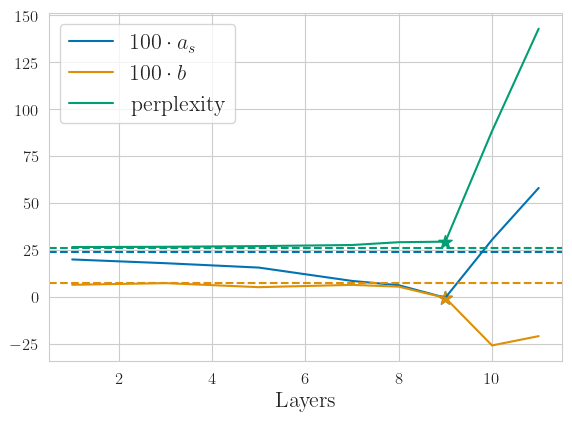

In [40]:
plot_line_plot(gen_res, lm_res, dimensionality=256, starred=9 , save_dir=OUTPUT_DIR, model_name=model_name)

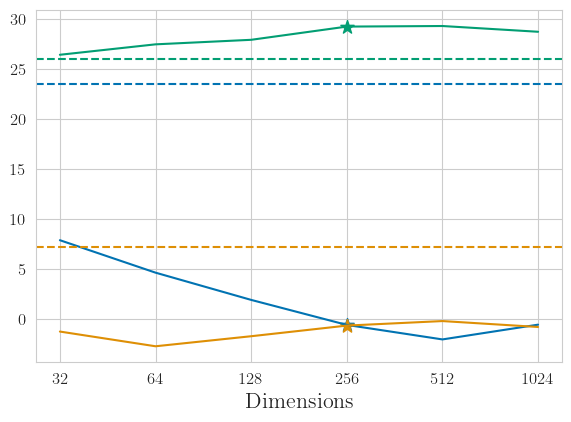

In [41]:
plot_line_plot(gen_res, lm_res, layers=9, starred=256, save_dir=OUTPUT_DIR, model_name=model_name)